In [10]:
from torch.optim import Adam
import torch
import torchvision
from torchvision.transforms import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
from model import Model
import mlflow
import matplotlib.pyplot as plt
from einops import rearrange
import torch.nn.functional as F
import tempfile

# Setup model + parameters

In [11]:
model = Model(num_classes=1)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model.to(device)

LR = 0.001
optimizer = Adam(model.parameters(), lr=LR)

EPOCHS = 2
IMG_SIZE = 32
BATCH_SIZE = 64
T = 300

Using device: cuda


# Datasets

In [12]:
data_transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
])

train = torchvision.datasets.FashionMNIST(root="./data", download=True, transform=data_transform, train=True)

test = torchvision.datasets.FashionMNIST(root="./data", download=True, transform=data_transform, train=False)


train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [13]:
# imgs, lbls = next(iter(train_dataloader))
# print(f"Image shape: {imgs.shape}, Labels shape: {lbls.shape}")

# def model_forward(model, imgs: torch.Tensor, t: torch.Tensor):
#     model.eval()
#     with torch.no_grad():
#         imgs = imgs.to(device)
#         noise_pred = model(imgs, t)
#         noise_pred = noise_pred.cpu().numpy()
#     return noise_pred

# noise_pred = model_forward(model, imgs, torch.empty((BATCH_SIZE, 1)).to(device))

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# axes[0].imshow(imgs[0].detach().cpu().squeeze(), cmap="gray")
# axes[1].imshow(noise_pred[0].squeeze(), cmap="gray")
# plt.show()

In [14]:
# t = torch.randint(1, 50, imgs.shape)

# imgs = imgs.to(device)
# noisy_imgs, noise, first_term, second_term = model.noise_scheduler(imgs, t)

# imgs = imgs.cpu()
# noisy_imgs = noisy_imgs.cpu()
# noise = noise.cpu()
# first_term = first_term.cpu()
# second_term = second_term.cpu()

# idx = 1
# img = imgs[idx]
# noisy_img = noisy_imgs[idx]
# noise_idx = noise[idx]
# first_term_idx = first_term[idx]
# second_term_idx = second_term[idx]

# plt.subplot(1, 4, 1)
# plt.imshow(rearrange(img, "b h w -> h w b"), cmap="gray")
# plt.title("Original Image")

# plt.subplot(1, 4, 2)
# plt.imshow(rearrange(noise_idx, "b h w -> h w b"), cmap="gray")
# plt.title("Noise")

# plt.subplot(1, 4, 3)
# plt.imshow(rearrange(noisy_img, "b h w -> h w b"), cmap="gray")
# plt.title("Noisy image")

# probably_original_image = noisy_img - first_term_idx - second_term_idx

# plt.subplot(1, 4, 4)
# plt.imshow(rearrange(probably_original_image, "b h w -> h w b"), cmap="gray")
# plt.title("Noisy image minus noise")

# plt.tight_layout()
# plt.show()

In [15]:
train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=data_transform)
test_dataset  = datasets.MNIST(root='../../data', train=False, download=True, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

Show noise schedule original image, noisy image, noise, and noisy image minus the noise

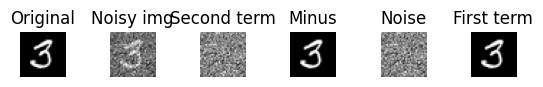

In [16]:
noise_sched = model.noise_scheduler
images, labels = next(iter(train_loader))

# Forward diffusion for the first image
image = images[0].to(device)
timestep = 100
noisy_img, noise, first_term, second_term = noise_sched.forward(image, timestep)

# Noisy image minus the noise
minus = noisy_img - second_term

# Plot different images
image = rearrange(image, "b h w -> h w b")
noisy_img = rearrange(noisy_img, "b h w -> h w b")
minus = rearrange(minus, "b h w -> h w b")
second_term = rearrange(second_term, "b h w -> h w b")
first_term = rearrange(first_term, "b h w -> h w b")
noise = rearrange(noise, "b h w -> h w b")

plt.subplot(1, 6, 1)
plt.imshow(image.cpu().numpy(), cmap='gray')
plt.title('Original')
plt.axis('off')
plt.subplot(1, 6, 2)
plt.imshow(noisy_img.cpu().numpy(), cmap='gray')
plt.title('Noisy img')
plt.axis('off')
plt.subplot(1, 6, 3)
plt.imshow(second_term.cpu().numpy(), cmap='gray')
plt.title('Second term')
plt.axis('off')
plt.axis('off')
plt.subplot(1, 6, 4)
plt.imshow(minus.cpu().numpy(), cmap='gray')
plt.title('Minus')
plt.axis('off')
plt.subplot(1, 6, 5)
plt.imshow(noise.cpu().numpy(), cmap='gray')
plt.title('Noise')
plt.axis('off')
plt.subplot(1, 6, 6)
plt.imshow(first_term.cpu().numpy(), cmap='gray')
plt.title('First term')
plt.axis('off')

plt.subplots_adjust(wspace=1)  # adjust this value as needed

plt.show()


Show noise schedule original image, noisy image, noise, 

# Train

In [ ]:
def get_loss(model, epoch, imgs: torch.Tensor, t: torch.Tensor):
    x_noisy, noise, first_term, second_term = model.noise_scheduler(imgs, t)
    noise_pred = model(x_noisy, t)
    loss = F.l1_loss(noise_pred, second_term) # Here we want to predict the noise. Second term is the noise / target to predict

    if epoch % 5 == 0:
        # Plot original image, noisy image, noise, and predicted noise
        idx = 0
        original_image = imgs[idx].cpu()
        noisy_image = x_noisy[idx].cpu()
        noise_idx = noise[idx].cpu()
        first_term_image = first_term[idx].cpu()
        second_term_image = second_term[idx].cpu()
        predicted_noise_image = noise_pred[idx].cpu().detach()
        t_idx = t[idx].cpu().item()
        minus = noisy_image - second_term_image

        fig, axes = plt.subplots(1, 7, figsize=(8, 8))
        axes[0].imshow(rearrange(original_image, "c h w -> h w c"), cmap="gray")
        axes[0].set_title("Original")

        axes[1].imshow(rearrange(noisy_image, "c h w -> h w c"), cmap="gray")
        axes[1].set_title("Noisy (t="+str(t_idx)+")")

        axes[2].imshow(rearrange(noise_idx, "c h w -> h w c"), cmap="gray")
        axes[2].set_title("Noise")

        axes[3].imshow(rearrange(first_term_image, "c h w -> h w c"), cmap="gray")
        axes[3].set_title("First term")

        axes[4].imshow(rearrange(second_term_image, "c h w -> h w c"), cmap="gray")
        axes[4].set_title("Second term")

        axes[5].imshow(rearrange(predicted_noise_image, "c h w -> h w c"), cmap="gray")
        axes[5].set_title("Predicted")

        axes[6].imshow(rearrange(minus, "c h w -> h w c"), cmap="gray")
        axes[6].set_title("(Noisy-Second)")


        plt.subplots_adjust(wspace=0.5)  # Increase gap between columns
        # plt.tight_layout()

        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
            fig.savefig(tmp.name)
            mlflow.log_artifact(tmp.name, artifact_path="images")  # optional path name inside MLflow
            print("Saved image: " + tmp.name)
            # mlflow.log_image(tmp, artifact_file=tmp.name)

        plt.close(fig)  # Clean up the figure

    return loss

Traceback (most recent call last):
  File "c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\mlflow\store\tracking\file_store.py", line 329, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\mlflow\store\tracking\file_store.py", line 427, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1373, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^

Saved image: C:\Users\Shlomi\AppData\Local\Temp\tmpez4pptp_.png


TypeError: Unsupported image object type: <class 'tempfile._TemporaryFileWrapper'>. `image` must be one of numpy.ndarray, PIL.Image.Image, and mlflow.Image.

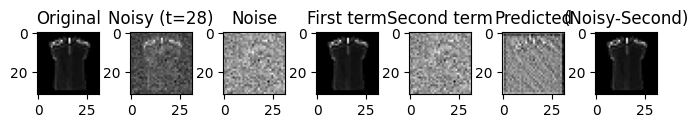

In [18]:
mlflow.set_experiment("MNIST Training")
mlflow.autolog()

with mlflow.start_run():
    mlflow.log_params({
        "lr": LR,
        "device": device,
        "optimizer": optimizer,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE
    })

    batch_step = 0
    
    for epoch in tqdm(range(EPOCHS), desc="Training", unit="epoch"):
        for step, batch in enumerate(train_dataloader):
            optimizer.zero_grad()

            imgs, labels = batch
            imgs = imgs.to(device)
            # labels = labels.to(device)

            t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
            loss = get_loss(model, epoch, imgs, t)

            mlflow.log_metric("loss", loss.item(), step=batch_step)
            batch_step += 1

            # Calculate gradients and update model parameters
            loss.backward()
            optimizer.step()

            #   if epoch % 5 == 0 and step == 0:
            #     print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            #     sample_plot_image()

# Save model
torch.save(model.state_dict(), "model.pth")

In [ ]:
# Load model
model = Model()
model.load_state_dict(torch.load("model.pth"))

